In [1]:
import os 
os.chdir('../../../')
print("Current working directory is now: ", os.getcwd())

import pandas as pd 
import numpy as np
import csv
import utils.interpretable_functions as interpret
import utils.RiskSLIM as slim
import utils.stumps as stumps
import utils.Corel as Corel

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score

# restore saved variables
%store -r summary_violent6_FL_interpret

Current working directory is now:  C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2


C:\Users\binha\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



### CART & EBM

In [2]:
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_data.csv")
x = data.loc[:,:'five_year']
y = data['recid_violent6'].values

In [3]:
#### CART
depth = [1,2]
impurity = [0.001, 0.003]
split = [2,3,4]
cart_summary = interpret.CART(X=x,
                         Y=y,
                         depth=depth,
                         split=split,
                         impurity=impurity, 
                         seed = 816)

#### EBM
estimators = [40,60,80]
depth = [1,2]
learning_rate = [0.01]
holdout_split = [0.7, 0.9]
ebm_summary = interpret.EBM(X=x,
                       Y=y,
                       learning_rate = learning_rate,
                       depth = depth,
                       estimators=estimators,
                       holdout_split=holdout_split,
                       seed=816)

model_id, score_thresholds 0 {'rank_abs': [0]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [0]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [0]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [2]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [0]}


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars



get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [0]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [0]}


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars



get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [0]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [0]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [0]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars



In [4]:
np.mean(cart_summary['holdout_test_auc']), np.mean(cart_summary['auc_diffs'])

(0.6239921791822678, 0.034711057896664156)

In [5]:
np.mean(ebm_summary['holdout_test_auc']), np.mean(ebm_summary['auc_diffs'])

(0.6768692402227486, 0.055869003792513805)

## Lasso Stumps

In [2]:
## load whole data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_stumps.csv")
X_stumps, Y_stumps = data.loc[:,:'five_year>=1'], data['recid_violent6'].values
Y_stumps[Y_stumps == -1] = 0
cols = X_stumps.columns[3:]

## load train & test data
train_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_train_stumps.csv")
test_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_test_stumps.csv")
X_train_stumps, Y_train_stumps = train_stumps.loc[:,:'five_year>=1'], train_stumps['recid_violent6'].values
X_test_stumps, Y_test_stumps = test_stumps.loc[:,:'five_year>=1'], test_stumps['recid_violent6'].values
Y_train_stumps[Y_train_stumps == -1] = 0
Y_test_stumps[Y_test_stumps == -1] = 0

#### Nested Cross Validation

In [3]:
stump_summary = stumps.stump_cv(X = X_stumps, 
                                Y = Y_stumps, 
                                columns=cols, 
                                c_grid={'C': [0.01, 0.03, 0.05, 0.07, 0.09, 0.11]}, 
                                seed = 816)

model_id, score_thresholds 0 {'rank_abs': [144]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [157]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [142]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [177]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars



model_id, score_thresholds 0 {'rank_abs': [139]}
get_disparity_predefined_group()


C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



In [4]:
stump_summary['best_params'], np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])

([{'C': 0.11}, {'C': 0.05}, {'C': 0.05}, {'C': 0.05}, {'C': 0.05}],
 0.681073101479709,
 0.06942539141584514)

In [5]:
stump_summary['holdout_test_auc']

[0.6518541086350975,
 0.7034107760751359,
 0.6384028892455859,
 0.7192542306178671,
 0.6924435028248588]

##### Best Stump Model

In [10]:
best_stump_model = stumps.stump_model(X_train_stumps, 
                                      Y_train_stumps, 
                                      X_test_stumps, 
                                      Y_test_stumps, 
                                      c=0.05, 
                                      columns=cols, 
                                      seed=816)
len(best_stump_model['features'])

17

##### Prediction Table

In [11]:
stumps.latex_stump_table(best_stump_model['coefs'], 
                         best_stump_model['features'], 
                         best_stump_model['intercept'], 
                         best_stump_model['dictionary'])

egin{tabular}{|l|r|r|} \hline
1. p_current_age>=19 & 2.5 & -... \ \hline
2. p_current_age>=23 & 8.1 & -... \ \hline
3. p_current_age>=33 & 9.4 & -... \ \hline
4. p_charge>=5 & 4.6 & -... \ \hline
5. current_violent>=1 & 61.9 & +... \ \hline
6. violent_conviction>=2 & 28.0 & +... \ \hline
7. violent_conviction>=3 & 16.4 & +... \ \hline
8. violent_conviction>=4 & 8.3 & +... \ \hline
9. violent_conviction>=5 & 26.0 & +... \ \hline
10. total_convictions>=1 & 12.2 & -... \ \hline
11. total_convictions>=4 & 6.3 & +... \ \hline
12. p_drug>=1 & 9.9 & -... \ \hline
13. years_since_last_crime>=0.5 & 31.2 & -... \ \hline
14. years_since_last_crime>=1 & 3.3 & -... \ \hline
15. years_since_last_crime>=2 & 43.0 & -... \ \hline
16. years_since_last_crime>=3 & 1.5 & -... \ \hline
17. years_since_last_crime>=4 & 9.8 & -... \ \hline
18. Intercept & 0.0 & -... \ \hline
	extbf{ADD POINTS FROM ROWS 1 TO 18}  &  	extbf{SCORE} & = ..... \ \hline
\multicolumn{3}{l}{Pr(Y = 1) = exp(score/100) / (1 + exp(score

##### Stumps Visualization

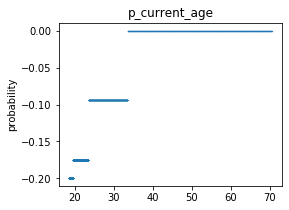

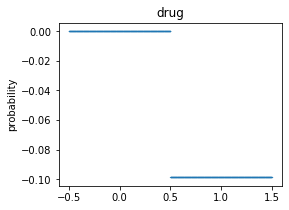

In [8]:
stumps.stump_plots(best_stump_model['features'], best_stump_model['coefs'], indicator='FL')

## RiskSLIM

In [12]:
## load stumps data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_stumps.csv")
x, y = data.loc[:,:'five_year>=1'], data['recid_violent6'].values
cols = x.columns[3:]

In [15]:
## train on best param chosen by Lasso Stumps from above
x_train = x.copy().drop(['race', 'person_id', 'screening_date'], axis=1)
lasso = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.05, random_state=816).fit(x_train,y)
selected_features = cols[lasso.coef_[0] != 0].tolist()
len(selected_features)

18

In [16]:
### Subset features
if 'sex>=1' in selected_features:
    selected_features = ['recid_violent6', 'person_id', 'screening_date', 'race'] + selected_features
    indicator = 1
else:
    selected_features = ['recid_violent6', 'person_id', 'screening_date', 'race', 'sex>=1'] + selected_features
    indicator = 0

sub_data = data[selected_features]
sub_X, sub_Y = sub_data.iloc[:,1:], sub_data.iloc[:,0].values
sub_X.insert(0, '(Intercept)', 1)

In [17]:
riskslim_summary = slim.risk_cv(X=sub_X, 
                                Y=sub_Y, 
                                indicator = indicator,
                                y_label='recid_violent6', 
                                max_coef=20, 
                                max_coef_number=10, 
                                max_runtime=200, 
                                c=1e-3, 
                                seed=816)

setting c0 = 0.0 to ensure that intercept is not penalized
09/30/19 @ 01:08 AM | 821 rows in lookup table
09/30/19 @ 01:08 AM | ------------------------------------------------------------
09/30/19 @ 01:08 AM | runnning initialization procedure
09/30/19 @ 01:08 AM | ------------------------------------------------------------
09/30/19 @ 01:08 AM | CPA produced 2 cuts
09/30/19 @ 01:08 AM | running naive rounding on 87 solutions
09/30/19 @ 01:08 AM | best objective value: 0.2720
09/30/19 @ 01:08 AM | rounding produced 1 integer solutions
09/30/19 @ 01:08 AM | best objective value is 0.3123
09/30/19 @ 01:08 AM | running sequential rounding on 87 solutions
09/30/19 @ 01:08 AM | best objective value: 0.2720
09/30/19 @ 01:08 AM | sequential rounding produced 2 integer solutions
09/30/19 @ 01:08 AM | best objective value: 0.2795
09/30/19 @ 01:08 AM | polishing 3 solutions
09/30/19 @ 01:08 AM | best objective value: 0.2795
09/30/19 @ 01:08 AM | polishing produced 3 integer solutions
09/30/19 @

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/30/19 @ 01:08 AM | adding 86 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.2795.
Tried aggregator 1 time.
Reduced MIP has 20 rows, 40 columns, and 75 nonzeros.
Reduced MIP has 18 binaries, 20 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variable

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



09/30/19 @ 01:09 AM | CPA produced 2 cuts
09/30/19 @ 01:09 AM | running naive rounding on 91 solutions
09/30/19 @ 01:09 AM | best objective value: 0.2698
09/30/19 @ 01:09 AM | rounding produced 1 integer solutions
09/30/19 @ 01:09 AM | best objective value is 0.2802
09/30/19 @ 01:09 AM | running sequential rounding on 91 solutions
09/30/19 @ 01:09 AM | best objective value: 0.2698
09/30/19 @ 01:09 AM | sequential rounding produced 1 integer solutions
09/30/19 @ 01:09 AM | best objective value: 0.2771
09/30/19 @ 01:09 AM | polishing 2 solutions
09/30/19 @ 01:09 AM | best objective value: 0.2771
09/30/19 @ 01:09 AM | polishing produced 2 integer solutions
09/30/19 @ 01:09 AM | initialization produced 2 feasible solutions
09/30/19 @ 01:09 AM | best objective value: 0.2771
09/30/19 @ 01:09 AM | ------------------------------------------------------------
09/30/19 @ 01:09 AM | completed initialization procedure
09/30/19 @ 01:09 AM | ----------------------------------------------------------

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/30/19 @ 01:09 AM | adding 90 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.2771.
Tried aggregator 1 time.
Reduced MIP has 20 rows, 40 columns, and 75 nonzeros.
Reduced MIP has 18 binaries, 20 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variable

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



09/30/19 @ 01:09 AM | CPA produced 2 cuts
09/30/19 @ 01:09 AM | running naive rounding on 105 solutions
09/30/19 @ 01:09 AM | best objective value: 0.2629
09/30/19 @ 01:09 AM | rounding produced 1 integer solutions
09/30/19 @ 01:09 AM | best objective value is 0.3046
09/30/19 @ 01:09 AM | running sequential rounding on 105 solutions
09/30/19 @ 01:09 AM | best objective value: 0.2629
09/30/19 @ 01:09 AM | sequential rounding produced 2 integer solutions
09/30/19 @ 01:09 AM | best objective value: 0.2678
09/30/19 @ 01:09 AM | polishing 3 solutions
09/30/19 @ 01:09 AM | best objective value: 0.2678
09/30/19 @ 01:09 AM | polishing produced 3 integer solutions
09/30/19 @ 01:09 AM | initialization produced 4 feasible solutions
09/30/19 @ 01:09 AM | best objective value: 0.2678
09/30/19 @ 01:09 AM | ------------------------------------------------------------
09/30/19 @ 01:09 AM | completed initialization procedure
09/30/19 @ 01:09 AM | --------------------------------------------------------

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/30/19 @ 01:09 AM | adding 104 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.2678.
Tried aggregator 1 time.
Reduced MIP has 20 rows, 40 columns, and 75 nonzeros.
Reduced MIP has 18 binaries, 20 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars



09/30/19 @ 01:09 AM | CPA produced 2 cuts
09/30/19 @ 01:09 AM | running naive rounding on 86 solutions
09/30/19 @ 01:09 AM | best objective value: 0.2755
09/30/19 @ 01:09 AM | rounding produced 2 integer solutions
09/30/19 @ 01:09 AM | best objective value is 0.3027
09/30/19 @ 01:09 AM | running sequential rounding on 86 solutions
09/30/19 @ 01:09 AM | best objective value: 0.2755
09/30/19 @ 01:09 AM | sequential rounding produced 1 integer solutions
09/30/19 @ 01:09 AM | best objective value: 0.2823
09/30/19 @ 01:09 AM | polishing 3 solutions
09/30/19 @ 01:09 AM | best objective value: 0.2823
09/30/19 @ 01:09 AM | polishing produced 3 integer solutions
09/30/19 @ 01:09 AM | initialization produced 5 feasible solutions
09/30/19 @ 01:09 AM | best objective value: 0.2820
09/30/19 @ 01:09 AM | ------------------------------------------------------------
09/30/19 @ 01:09 AM | completed initialization procedure
09/30/19 @ 01:09 AM | ----------------------------------------------------------

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/30/19 @ 01:09 AM | adding 85 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.2820.
Tried aggregator 1 time.
Reduced MIP has 20 rows, 40 columns, and 75 nonzeros.
Reduced MIP has 18 binaries, 20 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variable

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



09/30/19 @ 01:09 AM | CPA produced 2 cuts
09/30/19 @ 01:09 AM | running naive rounding on 108 solutions
09/30/19 @ 01:09 AM | best objective value: 0.2619
09/30/19 @ 01:09 AM | rounding produced 2 integer solutions
09/30/19 @ 01:09 AM | best objective value is 0.2853
09/30/19 @ 01:09 AM | running sequential rounding on 108 solutions
09/30/19 @ 01:09 AM | best objective value: 0.2619
09/30/19 @ 01:09 AM | sequential rounding produced 2 integer solutions
09/30/19 @ 01:09 AM | best objective value: 0.2716
09/30/19 @ 01:09 AM | polishing 4 solutions
09/30/19 @ 01:09 AM | best objective value: 0.2716
09/30/19 @ 01:09 AM | polishing produced 3 integer solutions
09/30/19 @ 01:09 AM | initialization produced 5 feasible solutions
09/30/19 @ 01:09 AM | best objective value: 0.2716
09/30/19 @ 01:09 AM | ------------------------------------------------------------
09/30/19 @ 01:09 AM | completed initialization procedure
09/30/19 @ 01:09 AM | --------------------------------------------------------

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/30/19 @ 01:09 AM | adding 107 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.2716.
Tried aggregator 1 time.
Reduced MIP has 20 rows, 40 columns, and 75 nonzeros.
Reduced MIP has 18 binaries, 20 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars



In [18]:
np.mean(riskslim_summary['train_auc']), np.mean(riskslim_summary['test_auc'])

(0.6818615414956736, 0.6545462919886222)

In [19]:
np.std(riskslim_summary['test_auc'])

0.030562977310656762

## Arnold PSA

In [23]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_arnold.csv")
X_arnold = data['arnold_nvca_raw'].values
Y_arnold = data['recid_violent6'].values

## set up cross validation
cv = KFold(n_splits=5,shuffle=True,random_state=816)
arnold_auc = []
for train, test in cv.split(X_arnold, Y_arnold):
    y_pred_arnold, y_test = X_arnold[test], Y_arnold[test]
    arnold_auc.append(roc_auc_score(y_test, y_pred_arnold))

### Corel

In [2]:
## load stumps data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_stumps.csv")
x, y = data.loc[:,:'five_year>=1'], data['recid_violent6'].values
y[y==-1]=0

In [5]:
corel_summary = Corel.corel_cv(x, y, max_card=2, c=1e-3, seed=816)

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:86: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:82: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:95: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\binha

In [6]:
np.mean(corel_summary['test_auc']), np.std(corel_summary['test_auc'])

(0.5, 0.0)

### Results

In [27]:
#### save results
summary_violent6_FL_interpret = {"CART": cart_summary,
                                 "EBM": ebm_summary, 
                                 'Lasso Stumps': stump_summary, 
                                 'RiskSLIM': riskslim_summary, 
                                 'Corel': corel_summary,
                                 'Arnold PSA': arnold_auc}
%store summary_violent6_FL_interpret

Stored 'summary_violent6_FL_interpret' (dict)


In [28]:
results = [["CART", np.mean(cart_summary['holdout_test_auc']), np.mean(cart_summary['auc_diffs'])],
           ["EBM", np.mean(ebm_summary['holdout_test_auc']), np.mean(ebm_summary['auc_diffs'])], 
           ["Lasso Stumps", np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])],
           ['RiskSLIM', np.mean(riskslim_summary['test_auc'])],
           ['Corel', np.mean(corel_summary['test_auc'])],
           ['Arnold PSA', round(np.mean(arnold_auc), 3)]]
results

[['CART', 0.6239921791822678, 0.034711057896664156],
 ['EBM', 0.6768692402227486, 0.055869003792513805],
 ['Lasso Stumps', 0.681073101479709, 0.06942539141584514],
 ['RiskSLIM', 0.6545462919886222],
 ['Corel', 0.5],
 ['Arnold PSA', 0.682]]

In [29]:
auc = [np.mean(cart_summary['holdout_test_auc']), 
       np.mean(ebm_summary['holdout_test_auc']), 
       np.mean(stump_summary['holdout_test_auc']), 
       np.mean(riskslim_summary['test_auc']), 
       np.mean(corel_summary['test_auc'])]

In [32]:
path = "C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/broward models/model results/Interpretable Models/Six Month/"
results = [["Violent", np.str((round(np.mean(cart_summary['holdout_test_auc']), 3))) + " (" + np.str(round(np.std(cart_summary['holdout_test_auc']), 3)) + ")", 
            np.str(round(np.mean(ebm_summary['holdout_test_auc']),3)) + " (" + np.str(round(np.std(ebm_summary['holdout_test_auc']), 3)) + ")", 
            np.str(round(np.mean(stump_summary['holdout_test_auc']),3)) + " (" + np.str(round(np.std(stump_summary['holdout_test_auc']), 3)) + ")",             
            np.str(round(np.mean(riskslim_summary['test_auc']),3)) + " (" + np.str(round(np.std(riskslim_summary['test_auc']), 3)) + ")", 
            np.str(round(np.mean(corel_summary['test_auc']),3)) + " (" + np.str(round(np.std(corel_summary['test_auc']), 3)) + ")", 
            round(np.max(auc) - np.min(auc), 3),
            np.str(round(np.mean(arnold_auc), 3)) + " (" + np.str(round(np.std(arnold_auc),3)) + ")"]]
with open(path + 'Interpretable Models Summary.csv', 'a') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(results)

In [31]:
cart_confusion = cart_summary['confusion_matrix_stats']
ebm_confusion = ebm_summary['confusion_matrix_stats']
riskslim_confusion = riskslim_summary['confusion_matrix_stats']
stumps_confusion = stump_summary['confusion_matrix_stats']
corel_confusion = corel_summary['confusion_matrix_stats']
#arnold_confusion = cart_summary['confusion_matrix_stats']

## save results
cart_confusion.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/broward models/model fairness/Six Month/violent/cart_confusion.csv', index=None,header=True)
ebm_confusion.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/broward models/model fairness/Six Month/violent/ebm_confusion.csv', index=None,header=True)
riskslim_confusion.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/broward models/model fairness/Six Month/violent/riskslim_confusion.csv', index=None,header=True)
stumps_confusion.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/broward models/model fairness/Six Month/violent/stumps_confusion.csv', index=None,header=True)
corel_confusion.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/broward models/model fairness/Six Month/violent/corel_confusion.csv', index=None,header=True)
#arnold_confusion.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/broward models/model fairness/Six Month/arnold_confusion.csv', index=None,header=True)